In [1]:
# Libraries
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.metrics import Metric
from itertools import product
from PIL import Image
from tqdm import tqdm
import os

In [2]:
# Connect Drive
from google.colab import drive
drive.mount(r'/content/drive',force_remount = True)
%cd /content/drive/MyDrive/Cascade

Mounted at /content/drive
/content/drive/MyDrive/Cascade


# Load data and models

## Load data

In [44]:
with open(file = '/content/drive/MyDrive/Cascade/data/lstm_cascade_test.json') as f:
    lstm_test_tuple = json.load(f)

with open(file = '/content/drive/MyDrive/Cascade/data/lstm_char_map.json') as f:
    char_map = json.load(f)

test_symbols, test_features, test_target = map(np.array, lstm_test_tuple)

test_df = pd.read_json("/content/drive/MyDrive/Cascade/data/cascade_test_df.json")

## Load models

In [4]:
# Load yolo
!pip install ultralytics
from ultralytics import YOLO
yolo_model = YOLO("/content/drive/MyDrive/Cascade/models/YOLO.pt")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 3.8 MB/s eta 0:00:00


In [5]:
# Load LSTM

@tf.keras.utils.register_keras_serializable()
class SeqAccuracy(Metric):
    def __init__(self, name='seq_accuracy', **kwargs):
        super(SeqAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1), dtype=tf.float32)
        N = tf.shape(y_true)[0]
        k = 0
        for i in range(N):
            if tf.reduce_all(tf.math.equal(y_true[i, :], y_pred[i, :])):
                k += 1

        self.total.assign_add(tf.cast(k, tf.float32))
        self.count.assign_add(tf.cast(N, tf.float32))

    def result(self):
        return tf.cond(
            tf.math.not_equal(self.count, 0),
            lambda: self.total / self.count,
            lambda: tf.constant(0.0, dtype=tf.float32)
        )

    def reset_state(self):
        self.total.assign(0)
        self.count.assign(0)


lstm_model = load_model('/content/drive/MyDrive/Cascade/models/LSTM.keras')

In [6]:
# Get indices of sequences correctly predicted
def correct_indexes(preds, target, patience = 0):

  correct_indexes = []

  for i in range(preds.shape[0]):
    sorted_pred = np.array(sorted(preds[i,:]))
    sorted_targ = np.array(sorted(target[i,:]))

    if np.sum(sorted_pred == sorted_targ) >= preds.shape[1] - patience :
      correct_indexes.append(i)

  return correct_indexes

In [7]:
# Takes the ouput of the YOLO model and shapes it in the LSTM input format
def from_image_path_to_LSTM_input(results, data_frame = test_df, char_map = char_map,
                                  max_length = 113, pad_token = char_map["PAD"],
                                  start_token = char_map["START"], end_token = char_map["END"]):

  prediction_list = []

  for result in tqdm(results):

    # Get image path and image width and height
    image_path = result.path
    image_file_name = os.path.basename(image_path)

    with Image.open(image_path) as img:
            image_width, image_height = img.size

    # Get prediction boxes and classes and image_path

    boxes = result.boxes.xyxy.tolist()
    classes = np.array(result.boxes.cls.tolist())

    # Normalize predictions boxes
    x1 = np.array([])
    y1 = np.array([])
    x2 = np.array([])
    y2 = np.array([])

    # Get x_min, y_min, x_max, y_max
    for box in boxes:
      x1 = np.append(x1, box[0])
      y1 = np.append(y1, box[1])
      x2 = np.append(x2, box[2])
      y2 = np.append(y2, box[3])

    # Normalize them
    x1 /= image_width
    x2 /= image_width
    y1 /= image_height
    y2 /= image_height

    # Extract x_center, y_center, box_heights and box_widhts
    x_center = (x1 +x2) / 2
    y_center = (y1 + y2) / 2
    box_heights = y2-y1
    box_widths = x2-x1

    # Shuffle the sequences:

    order = list(range(len(x_center)))
    np.random.shuffle(order)

    x_center = x_center[order]
    y_center = y_center[order]
    box_heights = box_heights[order]
    box_widths = box_widths[order]
    classes = classes[order]

    # Get target
    target = np.array([char_map[char] for char in list(data_frame[data_frame["filename"] == image_file_name]["full_latex_chars"])[0]])

    # Get right format (add 1 in classes to pass from the yolo_char_map symbols to the lstm_char_map)
    box_features = np.array(list(zip(x_center, y_center, box_heights, box_widths)))
    box_classes = np.array(classes) + 1

    # Add start_token, end_token and pad untill the max_length is reached
    box_classes = np.insert(box_classes, 0, start_token)
    box_classes = np.append(box_classes, end_token)
    box_classes = np.append(box_classes, [pad_token]*(max_length - len(box_classes)))

    # Add start_token, end_token and pad untill the max_length is reached
    box_features = np.insert(box_features, 0, [start_token]*4, axis = 0)
    box_features = np.insert(box_features, box_features.shape[0], [end_token]*4, axis = 0)
    box_features = np.insert(box_features, box_features.shape[0], [[pad_token]*4]*(max_length - box_features.shape[0]), axis = 0)

    # Add start_token, end_token and pad untill the max_length is reached
    target = np.insert(target, 0, start_token)
    target = np.append(target, end_token)
    target = np.append(target, [pad_token]*(max_length - len(target)))

    # Append to prediction list
    prediction_list.append((box_classes, box_features, target))

  # Unpack the results into separate arrays
  classes_list, box_features_list, target_list = zip(*prediction_list)

  # Stack arrays along the batch dimension
  batch_classes = np.stack(classes_list)
  batch_box_features = np.stack(box_features_list)
  batch_target = np.stack(target_list)

  return batch_classes, batch_box_features, batch_target


# EVALUATION
We will perform an **ablation study** on our cascade model.
We will evaluate the models using the following function:

In [8]:
# Number of correclty predicted sequences / number of sequences.
# The argument "sort" is used only in the case of comparing sequences that have been shuffled
# (only when we are checking the results of the YOLO fine tuning)

def sequence_accuracy(preds, targets, patience = 0, sort = False):

  N = preds.shape[0]
  k = 0

  for i in range(N):
    pred = preds[i,:]
    target = targets[i,:]

    if sort:
      pred = np.array(sorted(pred))
      target = np.array(sorted(target))

    if np.sum(pred == target) >= preds.shape[1] - patience :
      k += 1
  seq_accuracy = k / preds.shape[0]
  return seq_accuracy

Since we can make the **patience** parameter range from 0 to the max_length, we can represent our model performance with an accuracy curve.

In order to do so we will use the following function:

In [37]:
# Applies "sequence_accuracy" on a range of patiences
def sequence_accuracy_curve(preds, targets, sort = False, title = "",  max_patience = 30):
  # Get accuracies
  accuracies = [sequence_accuracy(preds, targets, patience = pad, sort = sort) for pad in range(max_patience)]

  fig = plt.figure(figsize=(8, 6))
  plt.plot(range(max_patience), accuracies, marker = 'o', color = "darkgreen")
  plt.xlabel("Patience")
  plt.ylabel("Accuracy")
  plt.ylim(0,1.1)
  plt.title(title)
  plt.xticks(range(max_patience), range(max_patience))
  plt.grid(linestyle='--', alpha=0.5)
  plt.show()

  return accuracies

## LSTM evaluation
In this section we will evaluate the **LSTM** model assuming that **YOLO** gave the perfect output.

In [10]:
# Get lstm predictions
right_input_lstm_predictions = lstm_model.predict([test_symbols, test_features]).argmax(axis=-1)

63/63 [==============================] - 260s 4s/step


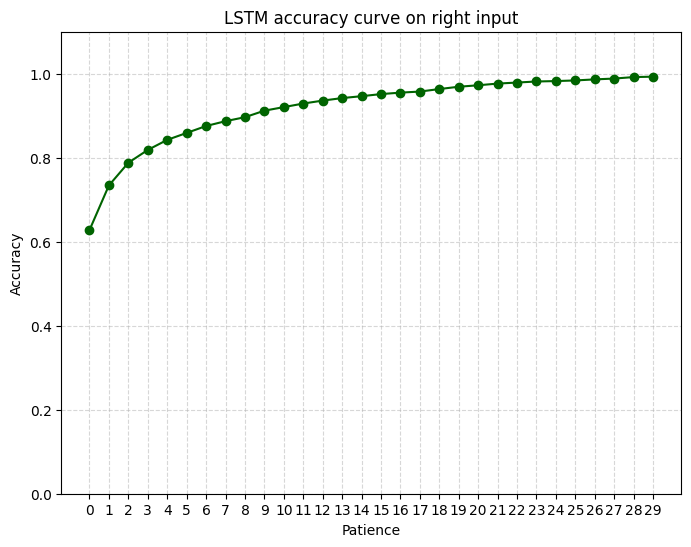

In [45]:
# Compute overall accuracy
right_input_lstm_accuracy_curve = sequence_accuracy_curve(right_input_lstm_predictions, test_target, title = "LSTM accuracy curve on right input")

In [42]:
right_input_lstm_accuracy_curve[0]

0.001

## YOLO evaluation

In this section we will evaluate the **YOLO** performance in giving the perfect output.

In [ ]:
# Get yolo predictions on test images
yolo_predictions = yolo_model.predict(source = "/content/drive/MyDrive/Cascade/data/YOLO_format/images", save_txt=False, save=False, stream=True)

In [12]:
# # Format them into the lstm shape
# yolo_predicted_symbols, yolo_predicted_features, yolo_target = from_image_path_to_LSTM_input(yolo_predictions)

# Or load it
with open("/content/drive/MyDrive/Cascade/data/yolo_predictions.json") as json_file:
    savable_lstm_yolo_predictions = json.load( json_file)
yolo_predicted_symbols, yolo_predicted_features, yolo_target  = map(np.array, savable_lstm_yolo_predictions)

In [13]:
# Get right order (uniform between the lstm input and the yolo target)
order = []
for j in tqdm(range(yolo_target.shape[0])):
  for i in range(test_target.shape[0]):
    if np.all(yolo_target[j,:] == test_target[i,:]):
      order.append(i)
      break

test_target = test_target[order]
test_symbols = test_symbols[order]
test_features = test_features[order]

100%|██████████| 2000/2000 [00:15<00:00, 130.44it/s]


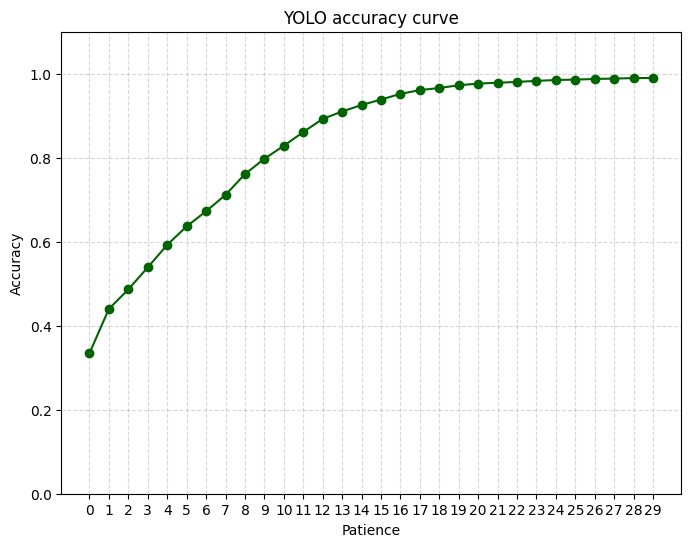

In [38]:
# Here we measure how many of the YOLO predicted sequences symbols are actually correct
yolo_prediction_accuracy_curve = sequence_accuracy_curve(yolo_predicted_symbols, test_symbols, sort = True, title = "YOLO accuracy curve")

This seems much lower then expected.

We obtain a $33.45$% of correclty corrected sequences while on the YOLO fine tuning we obtained an **MAP** of $97.5$%.

Why do we have this result then?

Let's consider for simplicity that the events of classyfing correctly each class are independent.

Then the probability of correctly classifying all $51$ classes within the same image would be : $0.975 ^{51} = 0.275$.


## CASCADE evaluation


In [15]:
# Get lstm predictions on yolo input
yolo_input_lstm_predictions = lstm_model.predict([yolo_predicted_symbols, yolo_predicted_features]).argmax(axis=-1)

63/63 [==============================] - 239s 4s/step


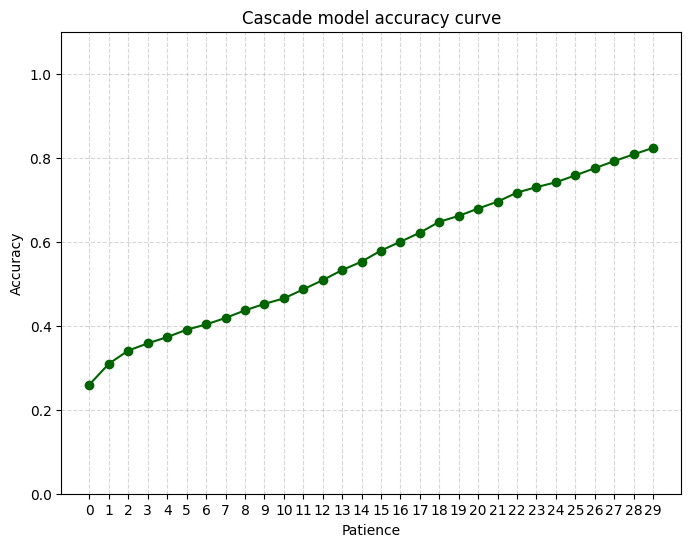

In [39]:
# Cascade model sequence accuracy
yolo_input_lstm_accuracy_curve = sequence_accuracy_curve(yolo_input_lstm_predictions, yolo_target, title = "Cascade model accuracy curve")

How much does the first model (**YOLO**) influence the performance of the second (**LSTM**) ?

In order to have a measure of this impact we decided to show how many sequences were correctly predicted by the **LSTM** giving increasingly wronger **YOLO** outputs (first just giving correctly predicted sequences, then adding those with just one error and so on).

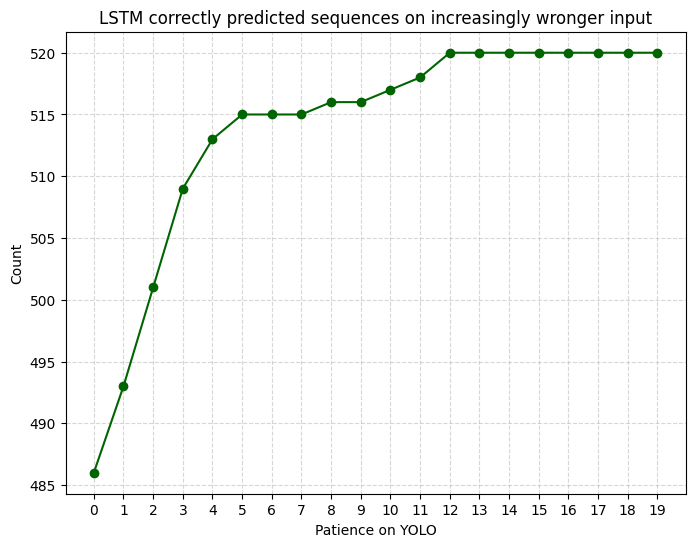

In [35]:
# Here is a picture of the global behaviour of the yolo model into sequence
fig = plt.figure(figsize = (8, 6))

patiences = range(20)
count_of_the_ltsm_on_increasingly_wronger_input = np.array([sequence_accuracy(yolo_input_lstm_predictions[correct_indexes(yolo_predicted_symbols, test_symbols, patience = i),:],
                                               yolo_target[correct_indexes(yolo_predicted_symbols, test_symbols, patience = i),:]) *
                                               yolo_target[correct_indexes(yolo_predicted_symbols, test_symbols, patience = i),:].shape[0]
                                                               for i in patiences])

plt.plot(patiences, count_of_the_ltsm_on_increasingly_wronger_input, marker = 'o', color = "darkgreen")
plt.xlabel("Patience on YOLO")
plt.ylabel("Count")
plt.title("LSTM correctly predicted sequences on increasingly wronger input")
custom_ticks = patiences
custom_labels = patiences
plt.xticks(custom_ticks, custom_labels)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

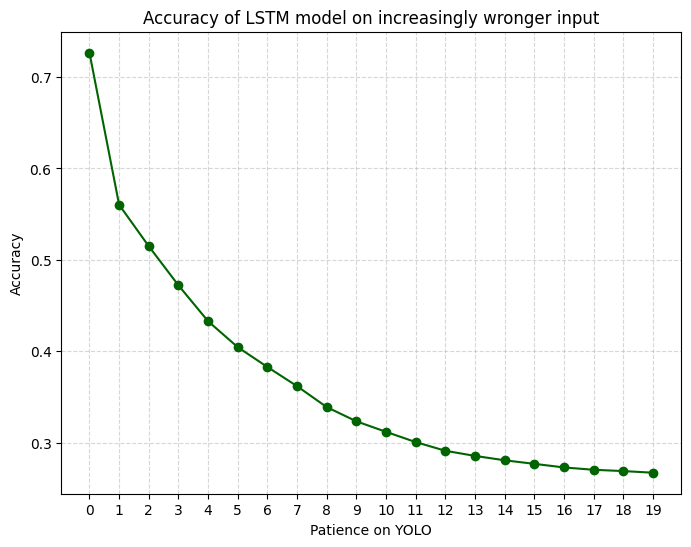

In [36]:
# Here is a picture of the global behaviour of the yolo model into sequence
fig = plt.figure(figsize = (8, 6))

patiences = range(20)
accuracy_of_the_ltsm_on_increasingly_wronger_input = np.array([sequence_accuracy(yolo_input_lstm_predictions[correct_indexes(yolo_predicted_symbols, test_symbols, patience = i),:],
                                               yolo_target[correct_indexes(yolo_predicted_symbols, test_symbols, patience = i),:]) for i in patiences])

plt.plot(patiences, accuracy_of_the_ltsm_on_increasingly_wronger_input, marker = 'o', color = "darkgreen")
plt.xlabel("Patience on YOLO")
plt.ylabel("Accuracy")
plt.title("Accuracy of LSTM model on increasingly wronger input")
custom_ticks = patiences
custom_labels = patiences
plt.xticks(custom_ticks, custom_labels)
plt.grid(linestyle='--', alpha=0.5)
plt.show()